In [1]:
import pymongo
from functional import seq
from shapely.geometry import Polygon, Point
from datetime import datetime, date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re

%matplotlib inline


In [80]:
vk_posts_collection = pymongo.MongoClient(host="192.168.13.133")['VkFest']['data_with_polarity_collection']
posts = seq(list(vk_posts_collection.find())).filter(lambda p:datetime(2016,7,16) <= datetime.fromtimestamp(p['date']) <= datetime(2016,7,18)) 
posts_mini = posts.take(1000)


In [5]:
vk_fest_zone = Polygon([(59.989681, 30.189350),
(59.985794, 30.192587),
(59.983390, 30.209195),
(59.978222, 30.206440),
(59.980459, 30.188407),
(59.980459, 30.188407),
(59.988639, 30.183686),
(59.989681, 30.189350)])

In [6]:
def by_geo(p):   
    return 'long' in p.keys()

def by_zone(p):   
    return vk_fest_zone.contains(Point(p['lat'], p['long']))

    
geoposts = posts.filter(by_geo)
zoneposts = geoposts.filter(by_zone)
print("Всего {} постов и фоток".format(posts.size()))
print("Всего {} постов и фоток с 15 июля"
      .format(posts.filter(lambda p: datetime.fromtimestamp(p['date']) > datetime(2016,7,15)).size()))    

print("С гео {} постов и фоток".format(geoposts.size()))
print("С гео в парке {} постов и фоток".format(zoneposts.size()))

Всего 459831 постов и фоток
Всего 456657 постов и фоток с 15 июля
С гео 147270 постов и фоток
С гео в парке 12433 постов и фоток


In [56]:
def time_hour(p):
    time = datetime.fromtimestamp(p['date'])
    return (time.year, time.month, time.day, time.hour)

def time_10min(p):
    time = datetime.fromtimestamp(p['date'])
    return (time.year, time.month, time.day, time.hour, time.minute/6)

def time_30min(p):
    time = datetime.fromtimestamp(p['date'])
    return (time.year, time.month, time.day, time.hour, time.minute/2)

In [7]:
posts_activity = posts \
    .group_by(time_hour) \
    .map(lambda g: ((datetime(g[0][0],g[0][1],g[0][2],g[0][3],0,0), seq(g[1]).len()))) \
    .sorted(lambda g: g[0]) \
    .filter(lambda g: g[0] > datetime(2016,7,15))

    
geoposts_activity = geoposts \
    .group_by(time_hour) \
    .map(lambda g: ((datetime(g[0][0],g[0][1],g[0][2],g[0][3],0,0), seq(g[1]).len()))) \
    .sorted(lambda g: g[0]) \
    .filter(lambda g: g[0] > datetime(2016,7,15))

zoneposts_activity = zoneposts \
    .group_by(time_hour) \
    .map(lambda g: ((datetime(g[0][0],g[0][1],g[0][2],g[0][3],0,0), seq(g[1]).len()))) \
    .sorted(lambda g: g[0]) \
    .filter(lambda g: g[0] > datetime(2016,7,15))



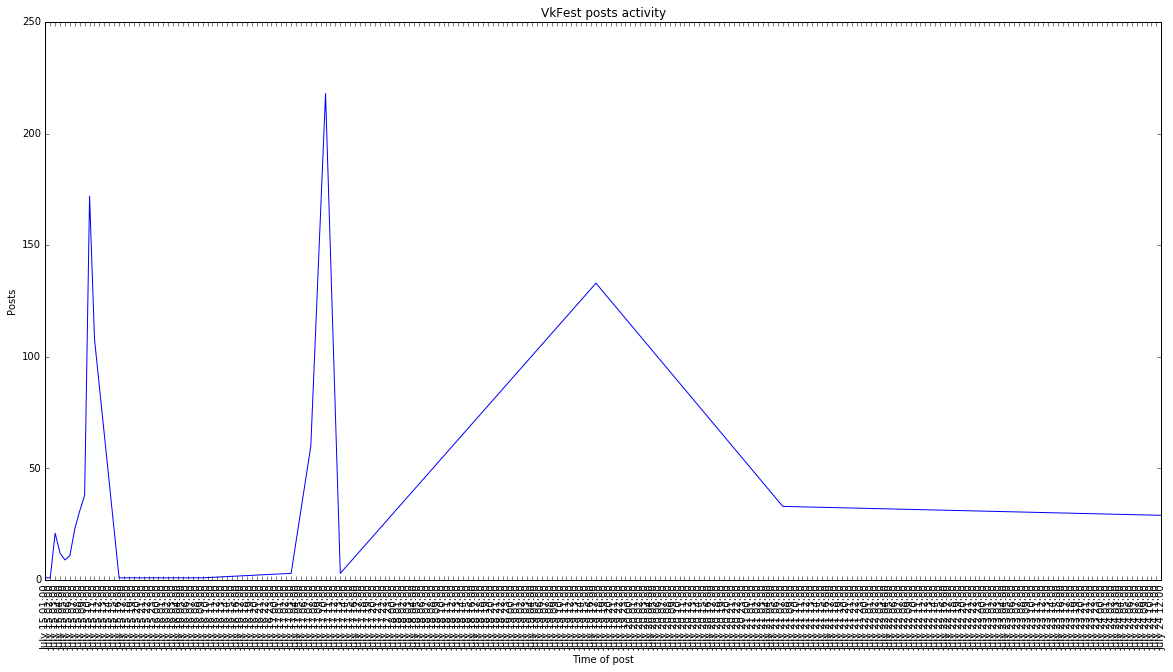

In [8]:
posts_mini_activity = posts_mini \
    .group_by(time_hour) \
    .map(lambda g: ((datetime(g[0][0],g[0][1],g[0][2],g[0][3],0,0), seq(g[1]).len()))) \
    .sorted(lambda g: g[0]) \
    .filter(lambda g: g[0] > datetime(2016,7,15))
    
plt.figure(figsize=(20, 10), dpi=300)
plt.title(u'VkFest posts activity')
plt.xlabel(u'Time of post')
plt.ylabel(u'Posts')
plt.plot(list(posts_mini_activity.map(lambda g: g[0])),list(posts_mini_activity.map(lambda g: g[1])), color="blue", linewidth=1.0)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('July %d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.xticks(rotation=90)
plt.show()    

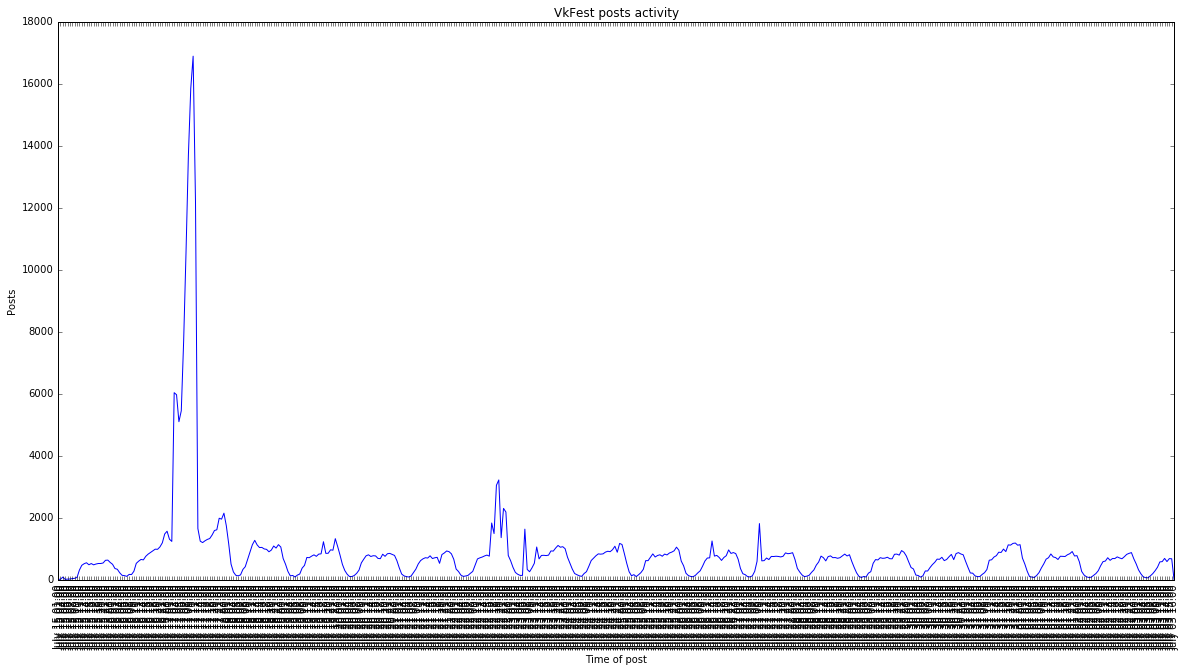

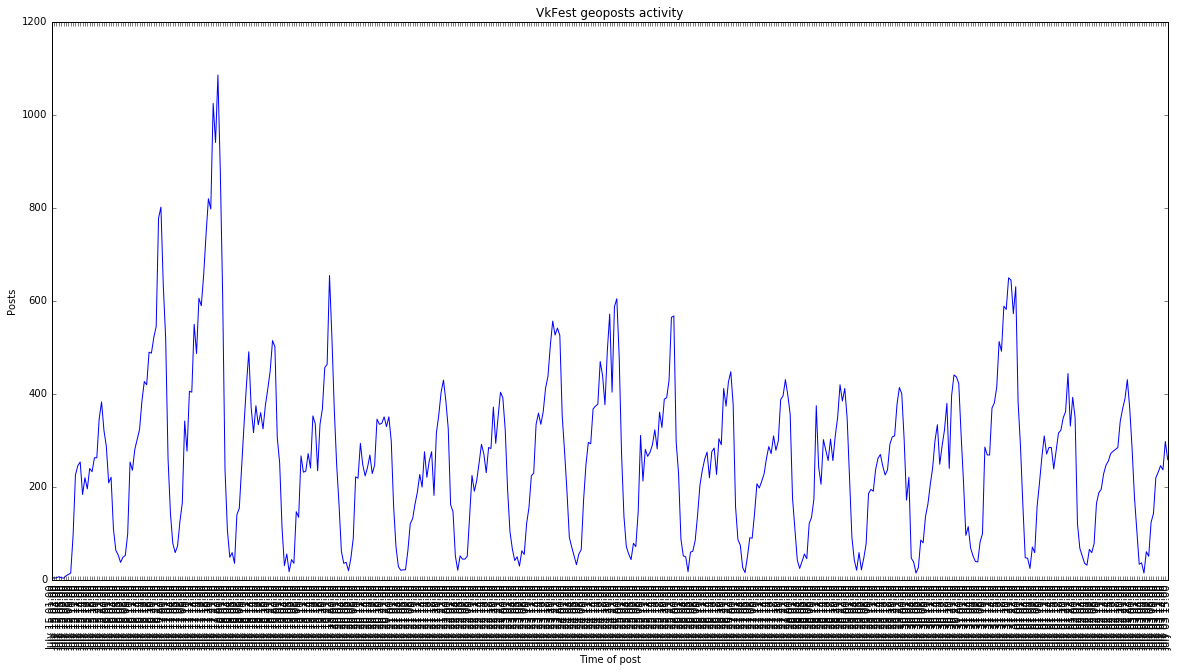

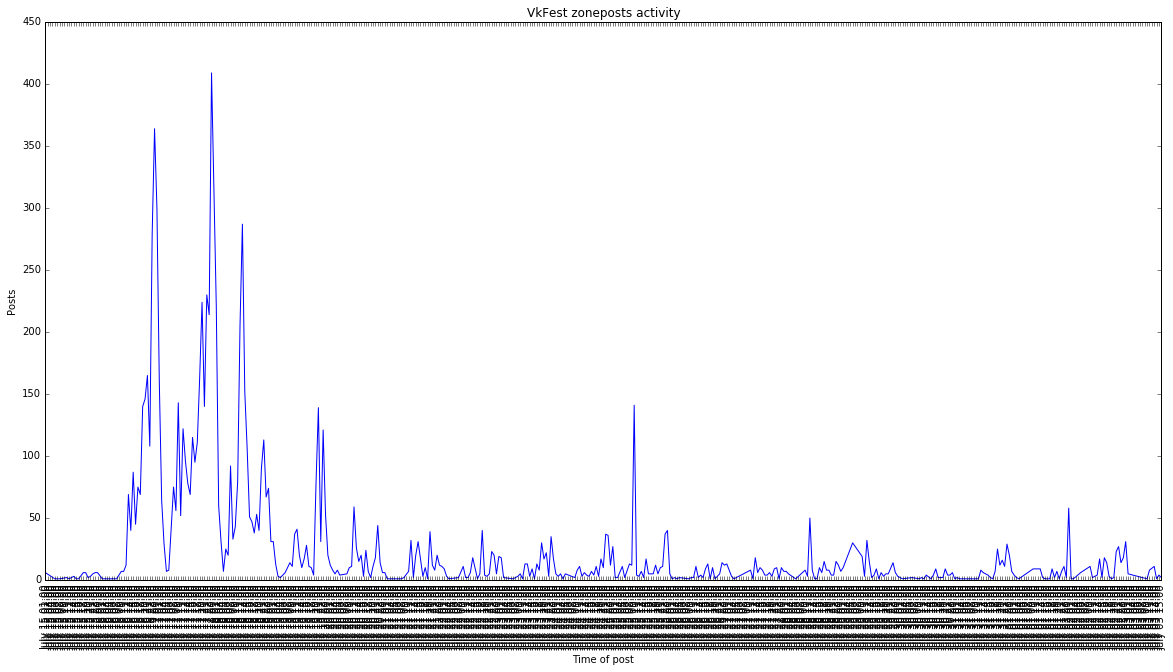

In [9]:
plt.figure(figsize=(20, 10), dpi=300)
plt.title(u'VkFest posts activity')
plt.xlabel(u'Time of post')
plt.ylabel(u'Posts')
plt.plot(list(posts_activity.map(lambda g: g[0])),list(posts_activity.map(lambda g: g[1])), color="blue", linewidth=1.0)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('July %d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(20, 10), dpi=300)
plt.title(u'VkFest geoposts activity')
plt.xlabel(u'Time of post')
plt.ylabel(u'Posts')
plt.plot(list(geoposts_activity.map(lambda g: g[0])),list(geoposts_activity.map(lambda g: g[1])), color="blue", linewidth=1.0)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('July %d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(20, 10), dpi=300)
plt.title(u'VkFest zoneposts activity')
plt.xlabel(u'Time of post')
plt.ylabel(u'Posts')
plt.plot(list(zoneposts_activity.map(lambda g: g[0])),list(zoneposts_activity.map(lambda g: g[1])), color="blue", linewidth=1.0)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('July %d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.xticks(rotation=90)
plt.show()

сколько с фото и сколько без

In [11]:
print(posts.size())
print(posts.filter(lambda p: 'photo_url' in p.keys()).size())

400669
291716


с хештегом '#vkfest'

In [12]:
print(posts.filter(lambda p: '#vkfest' in p['text']).size())

16807


пересечение постов с хештегом '#vkfest' и посты в зонаме вкфеста

In [14]:
posts.filter(lambda p: '#vkfest' in p['text']).map(lambda p:p['_id']).intersection(zoneposts.map(lambda p:p['_id'])).size()

566

всего хештегов

In [16]:
tag_regex = re.compile('(#\w+)')

In [17]:
posts.flat_map(lambda p: tag_regex.findall(p['text'])).size()

952414

топ хешей

In [18]:
hashes = posts.flat_map(lambda p: tag_regex.findall(p['text'])) \
    .map(lambda h: (h,1)) \
    .group_by(lambda g: g[0]) \
    .map(lambda g: (g[0], len(g[1]))) \
    .sorted(lambda g: g[1], reverse=True) \

print("20 самых популярных тегов")
hashes.take(20).for_each(print)
print("Всего {}".format(hashes.size()))

20 самых популярных тегов
('#спб', 34217)
('#питер', 31295)
('#Питер', 25019)
('#spb', 20393)
('#vkfest', 16227)
('#санктпетербург', 16048)
('#парк', 10312)
('#СПБ', 9842)
('#СанктПетербург', 8800)
('#лето', 7777)
('#новости', 7547)
('#piter', 7470)
('#Петербург', 7309)
('#Спб', 6840)
('#pokemongo', 6755)
('#События', 6442)
('#покемоны', 6241)
('#СПб', 5727)
('#pokemon', 4843)
('#Покемоны', 4320)
Всего 114977


In [19]:
hashes = zoneposts.flat_map(lambda p: tag_regex.findall(p['text'])) \
    .map(lambda h: (h,1)) \
    .group_by(lambda g: g[0]) \
    .map(lambda g: (g[0], len(g[1]))) \
    .sorted(lambda g: g[1], reverse=True) \

print("20 самых популярных тегов из зоны парка")
hashes.take(20).for_each(print)
print("Всего {}".format(hashes.size()))

20 самых популярных тегов из зоны парка
('#vkfest', 546)
('#vkfest2016', 124)
('#spb', 45)
('#вкфест', 44)
('#vk', 37)
('#saintpetersburg', 25)
('#спб', 20)
('#питер', 19)
('#санктпетербург', 16)
('#парк300летия', 15)
('#weekend', 14)
('#VKfest', 13)
('#Питер', 12)
('#russia', 11)
('#фестивальвконтакте', 11)
('#summer', 11)
('#beach', 10)
('#piter', 9)
('#лето', 8)
('#настроение', 8)
Всего 739


активность только постов с с хештегом '#vkfest'

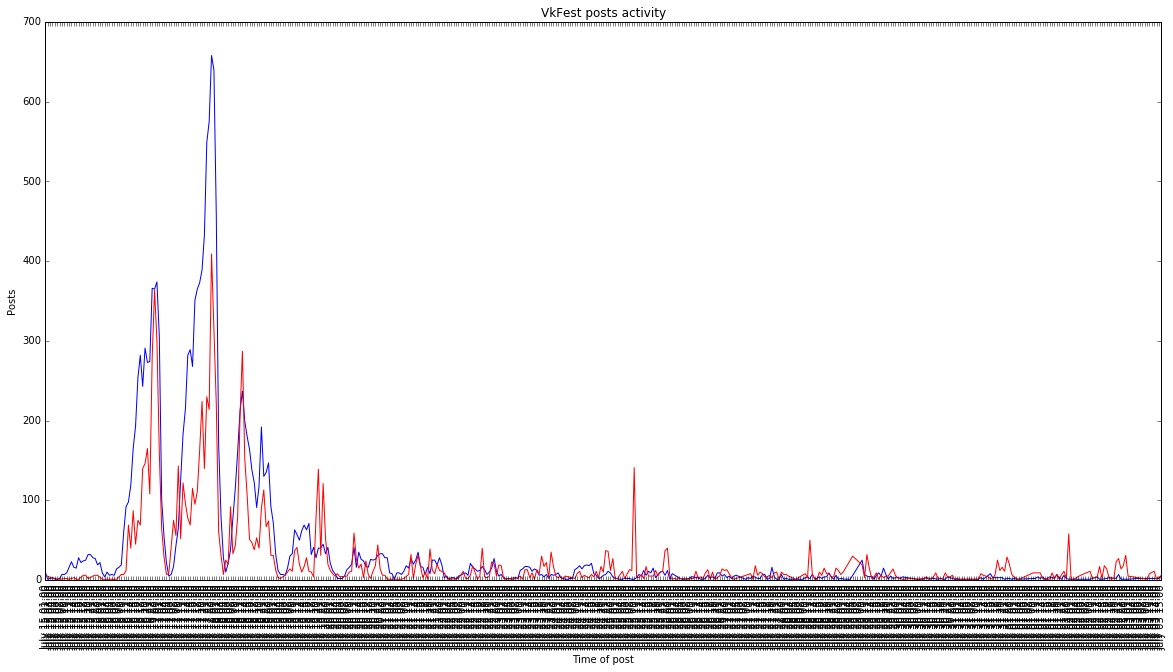

In [20]:
vk_fest_posts_activity = posts.filter(lambda p: '#vkfest' in p['text']) \
    .group_by(time_hour) \
    .map(lambda g: ((datetime(g[0][0],g[0][1],g[0][2],g[0][3],0,0), len(g[1])))) \
    .sorted(lambda g: g[0]) \
    .filter(lambda g: g[0] > datetime(2016,7,15))
    

plt.figure(figsize=(20, 10), dpi=300)
plt.title(u'VkFest posts activity')
plt.xlabel(u'Time of post')
plt.ylabel(u'Posts')
plt.plot(list(vk_fest_posts_activity.map(lambda g: g[0])),list(vk_fest_posts_activity.map(lambda g: g[1])), color="blue", linewidth=1.0)
plt.plot(list(zoneposts_activity.map(lambda g: g[0])),list(zoneposts_activity.map(lambda g: g[1])), color="red", linewidth=1.0)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('July %d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.xticks(rotation=90)
plt.show()

активность хештегов по времени

In [21]:
def by_top_hashes(posts):
    return seq(posts).flat_map(lambda p: tag_regex.findall(p['text'])) \
        .map(lambda h: (h,1)) \
        .group_by(lambda g: g[0]) \
        .map(lambda g: (g[0], len(g[1]))) \
        .sorted(lambda g: g[1], reverse=True) \
        .take(5)
    
posts_activity = posts.filter(lambda p: '#vkfest' in p['text']) \
    .group_by(time_hour) \
    .map(lambda g: (datetime(g[0][0],g[0][1],g[0][2],g[0][3],0,0), g[1])) \
    .sorted(lambda g: g[0]) \
    .filter(lambda g: g[0] > datetime(2016,7,15)) \
    .map(lambda g:(g[0],by_top_hashes(g[1])))

posts_activity.for_each(lambda g: print(g[0],g[1]))

2016-07-15 01:00:00 [('#vkfest', 10), ('#music', 2), ('#покемоныvkfest', 2), ('#food', 2), ('#впитеребыть', 1)]
2016-07-15 02:00:00 [('#vkfest', 1)]
2016-07-15 04:00:00 [('#vkfest', 3), ('#Шерп', 1), ('#spb', 1), ('#Sherp', 1)]
2016-07-15 06:00:00 [('#vkfest', 1)]
2016-07-15 07:00:00 [('#vkfest', 2), ('#vk', 1)]
2016-07-15 08:00:00 [('#vkfest', 7), ('#sport', 2), ('#VKfest', 1), ('#extreme', 1), ('#vk', 1)]
2016-07-15 09:00:00 [('#vkfest', 7), ('#микрокомикон', 1), ('#AVAExpo', 1), ('#gorenjevk', 1), ('#арткондитерскаясергеямагаева', 1)]
2016-07-15 10:00:00 [('#vkfest', 9), ('#vkfest2016', 2), ('#фестивальвконтакте', 2), ('#ростов', 1), ('#финскийзалив', 1)]
2016-07-15 11:00:00 [('#vkfest', 16), ('#покемоныvkfest', 2), ('#микрокомикон', 1), ('#extreme', 1), ('#bigfest', 1)]
2016-07-15 12:00:00 [('#vkfest', 26), ('#vkfest2016', 4), ('#sport', 2), ('#art', 2), ('#bonacapona', 1)]
2016-07-15 13:00:00 [('#vkfest', 16), ('#djfeel', 2), ('#заметкидиджея', 2), ('#feelontour', 2), ('#WATTS', 2

group by owner id

распределение постов по людям (сколько постов на человека)

616


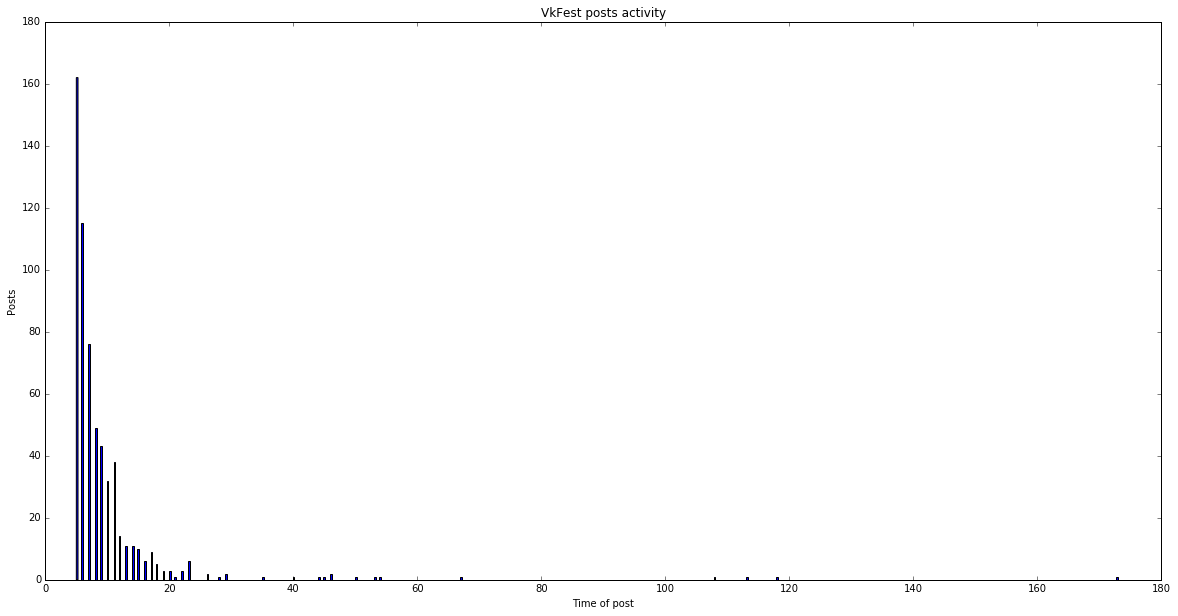

In [22]:
d = posts.filter(lambda p: '#vkfest' in p['text']) \
    .group_by(lambda p: p['owner_id']) \
    .map(lambda g: (g[0], len(g[1]))) \
    .sorted(lambda g: g[1],reverse=True) \
    .filter(lambda g: g[1] >= 5)
    
print(d.len())
 
    
    
plt.figure(figsize=(20, 10), dpi=300)
plt.title(u'VkFest posts activity')
plt.xlabel(u'Time of post')
plt.ylabel(u'Posts')
plt.hist(list(d.map(lambda g: g[1])), bins=d.len(), color="blue", linewidth=1.0)
plt.show()
    

zone groupping

посты с зоной

In [33]:
posts_with_zone = posts.filter(lambda p: p['zone'] not in ['nozone'])
print("",posts_with_zone.size())

 8590


зоны

In [30]:
posts_grouped_by_zone = posts_with_zone.group_by(lambda p: p['zone'])
posts_grouped_by_zone.map(lambda p: p[0])

['recordstage', 'market', 'bloggers', 'drive', 'extreme', 'whitestage', 'games', 'innovations', 'bluestage', 'compgames', 'vkfest', 'humor', 'kosplay', 'sport', 'art', 'vkshop', 'food', 'megafon', 'lecture', 'kids', 'fashion']

recordstage 15
market 69
bloggers 447
drive 1375
extreme 230
whitestage 411
games 227
innovations 147
bluestage 1050
compgames 365
vkfest 341
humor 152
kosplay 522
sport 760
art 835
vkshop 295
food 801
megafon 238
lecture 29
kids 159
fashion 122


/home/vipmax/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


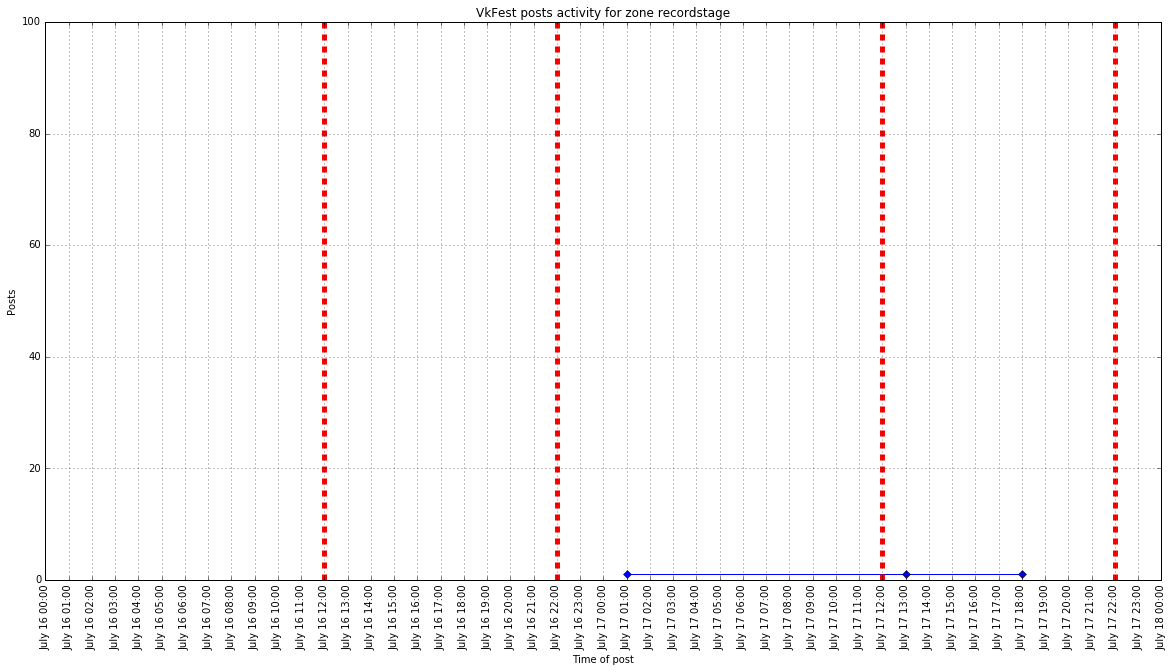

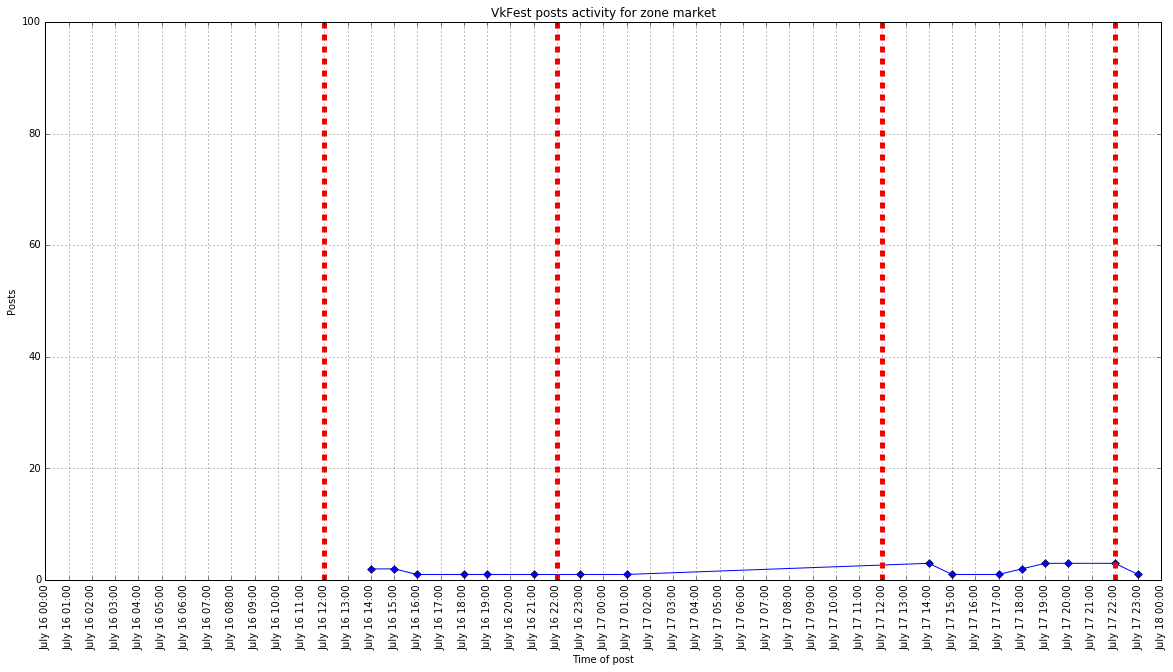

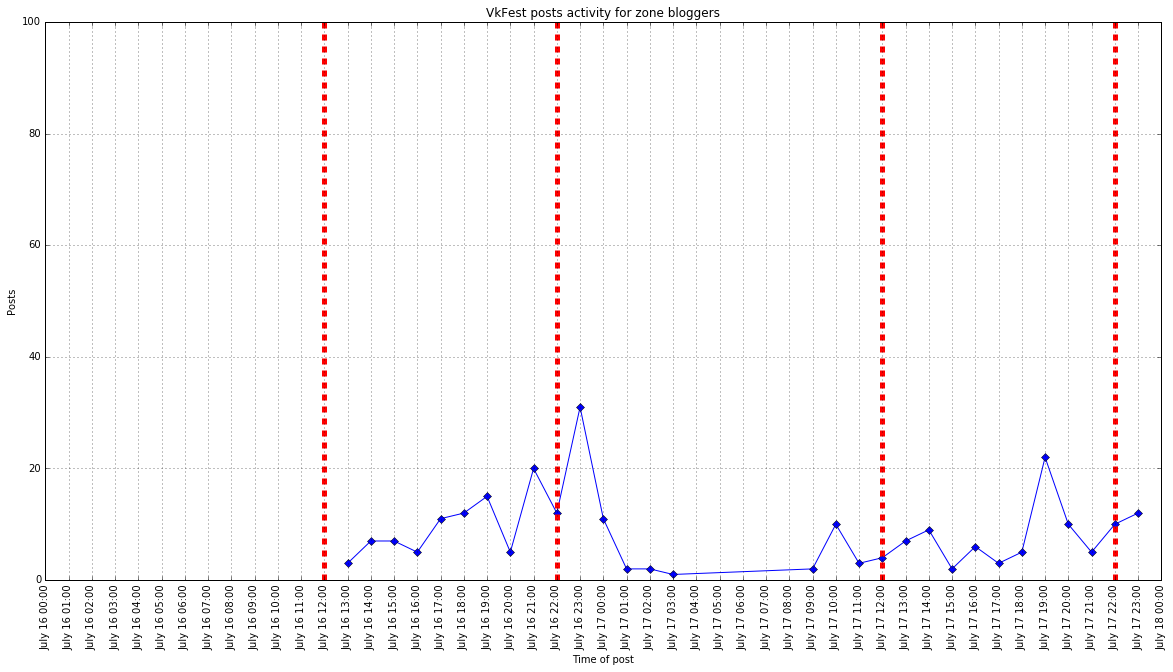

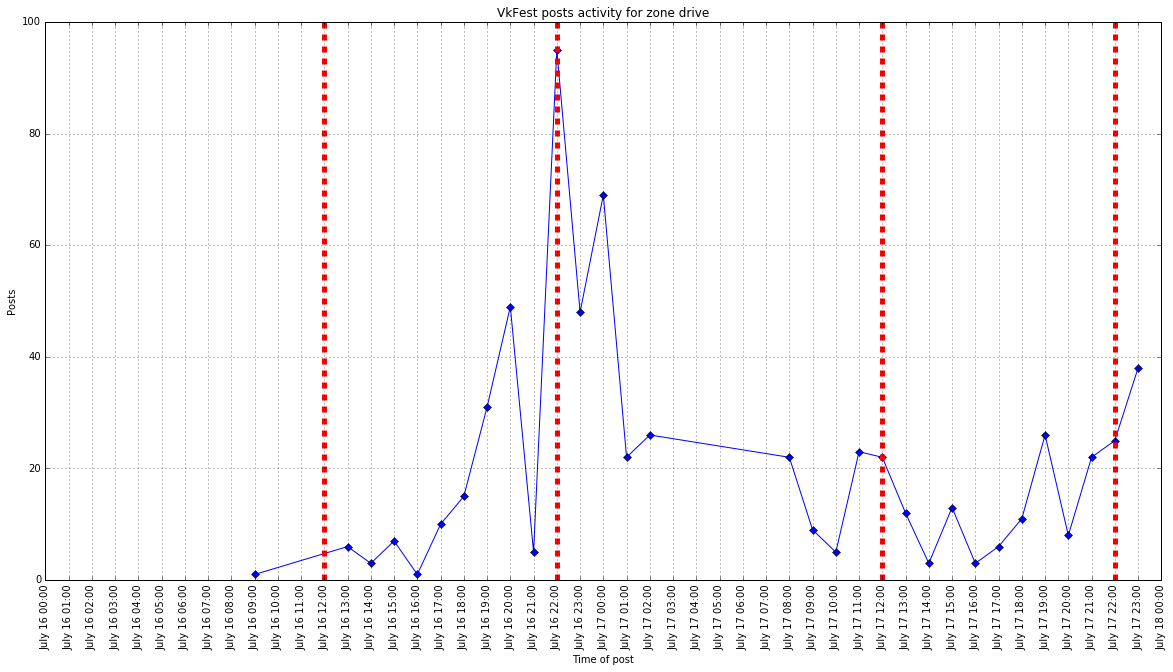

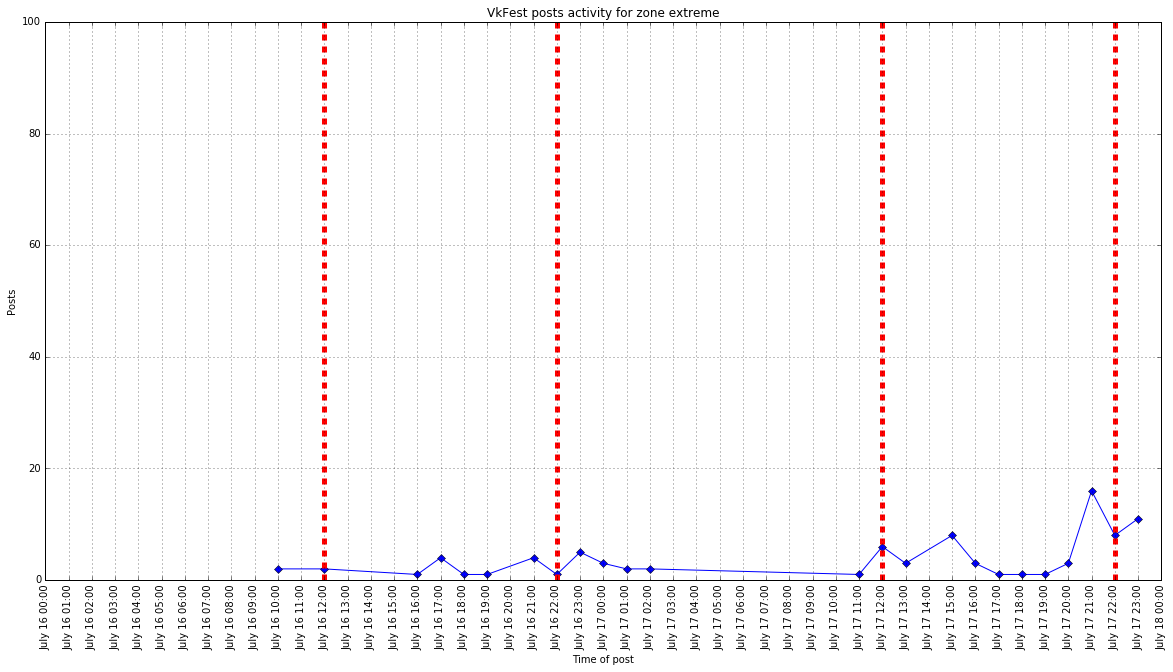

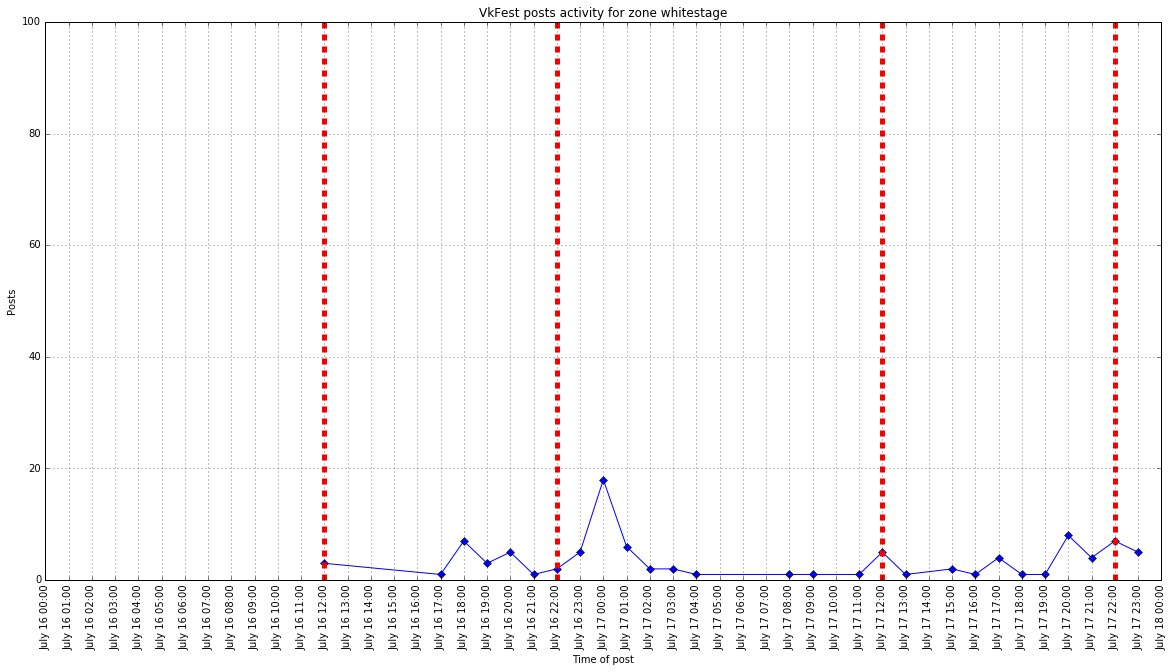

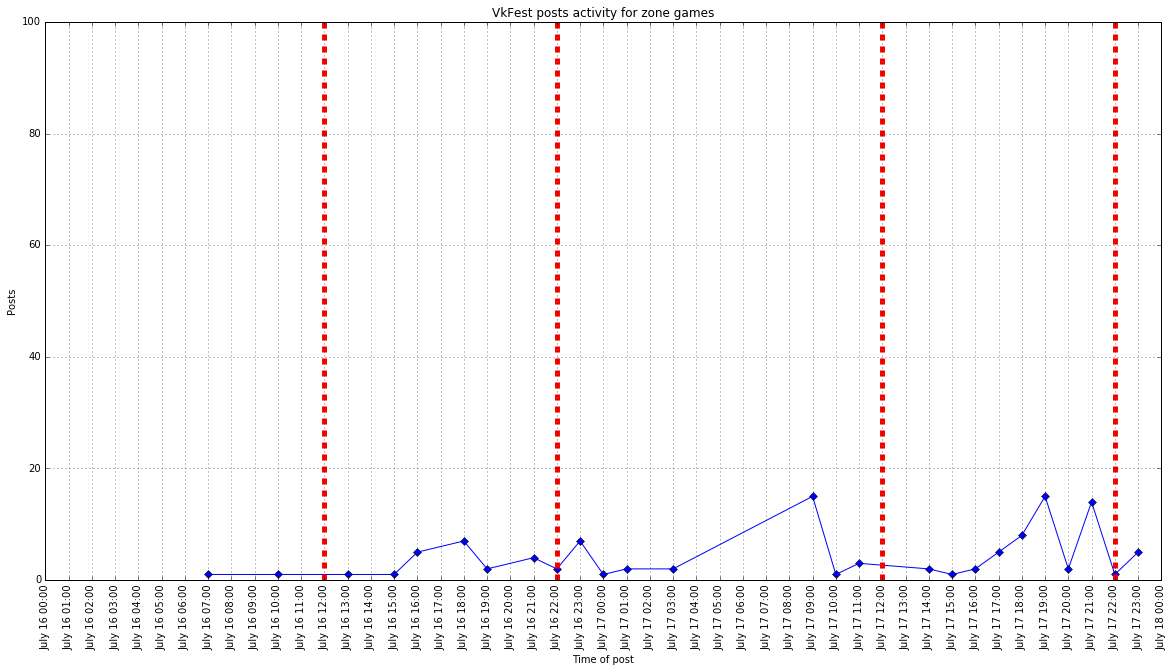

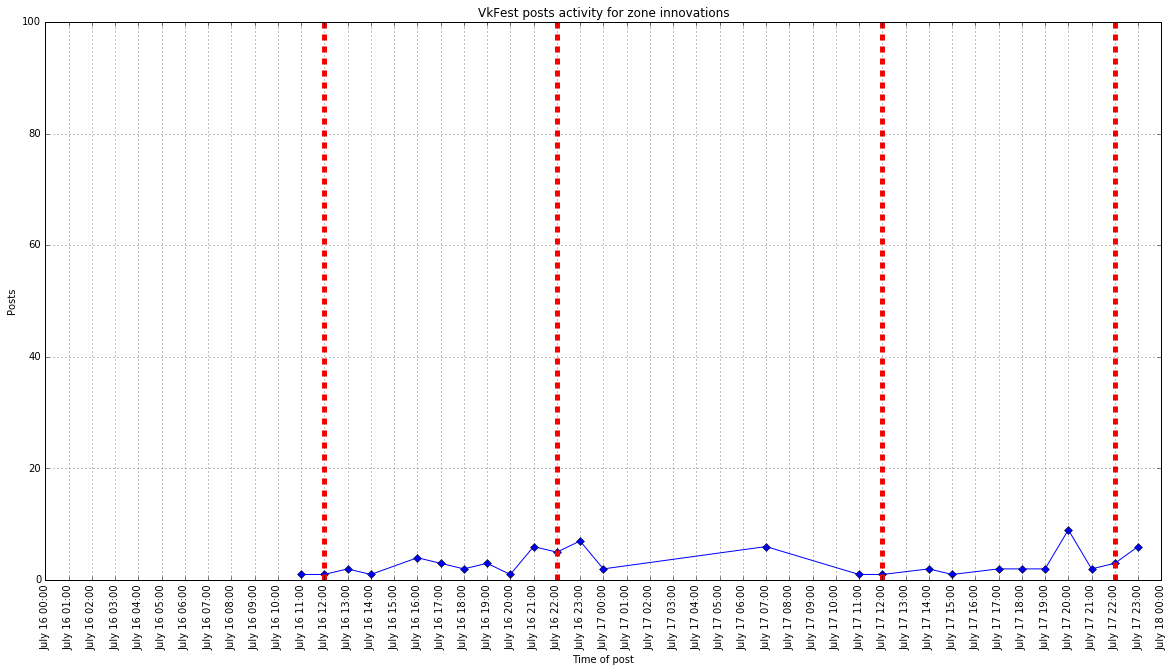

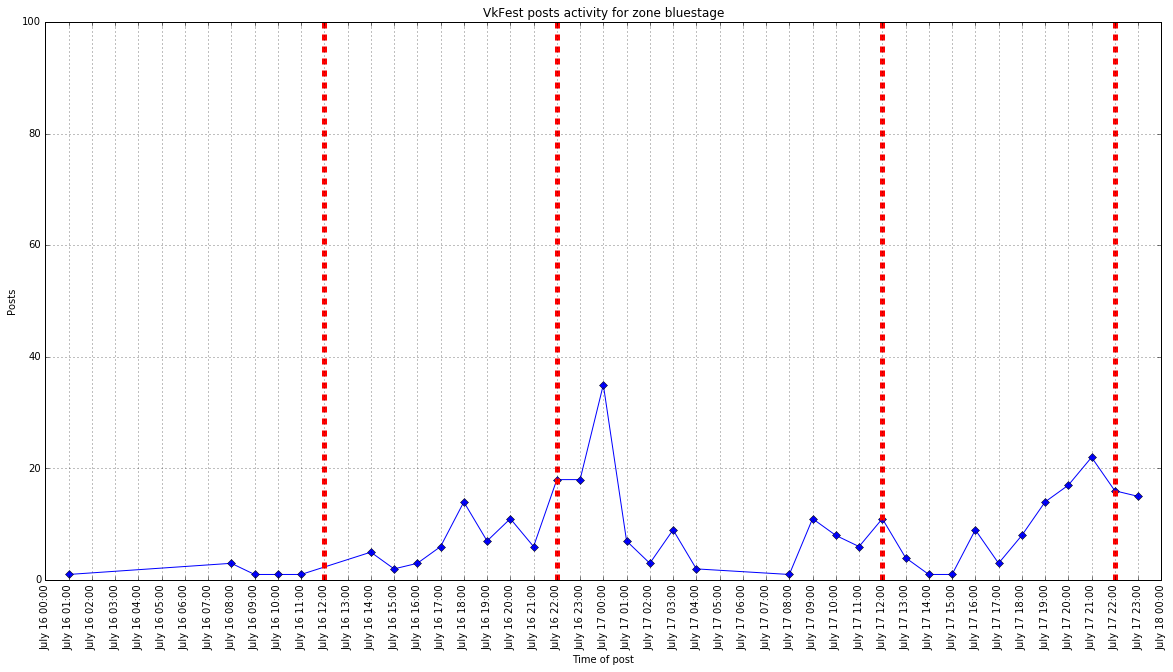

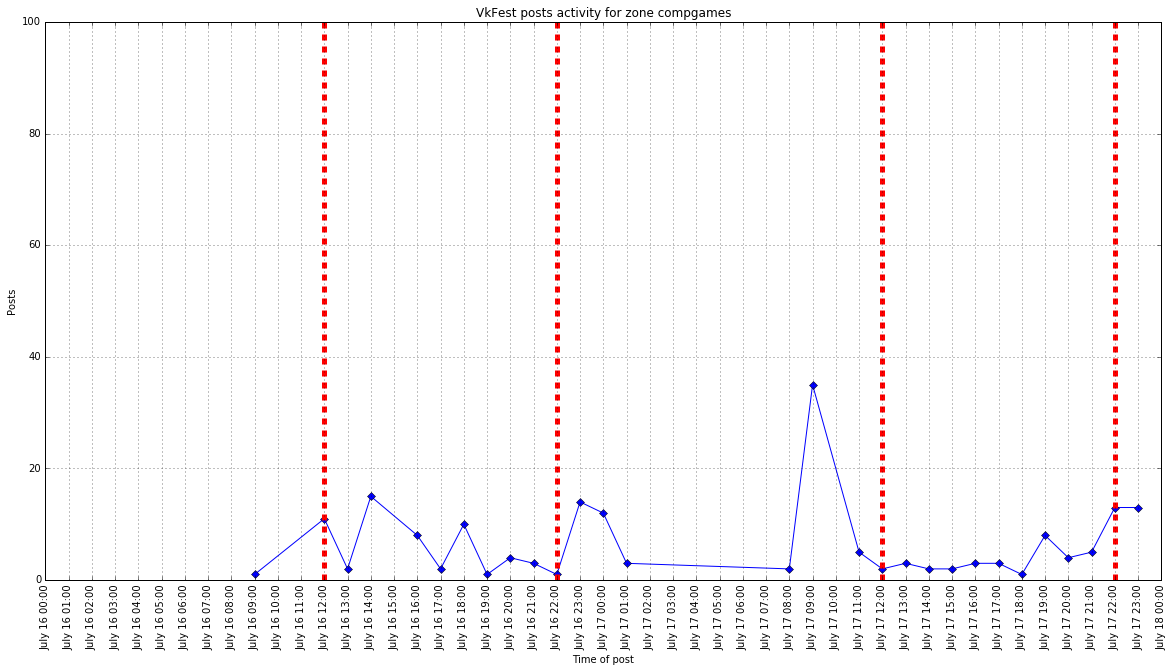

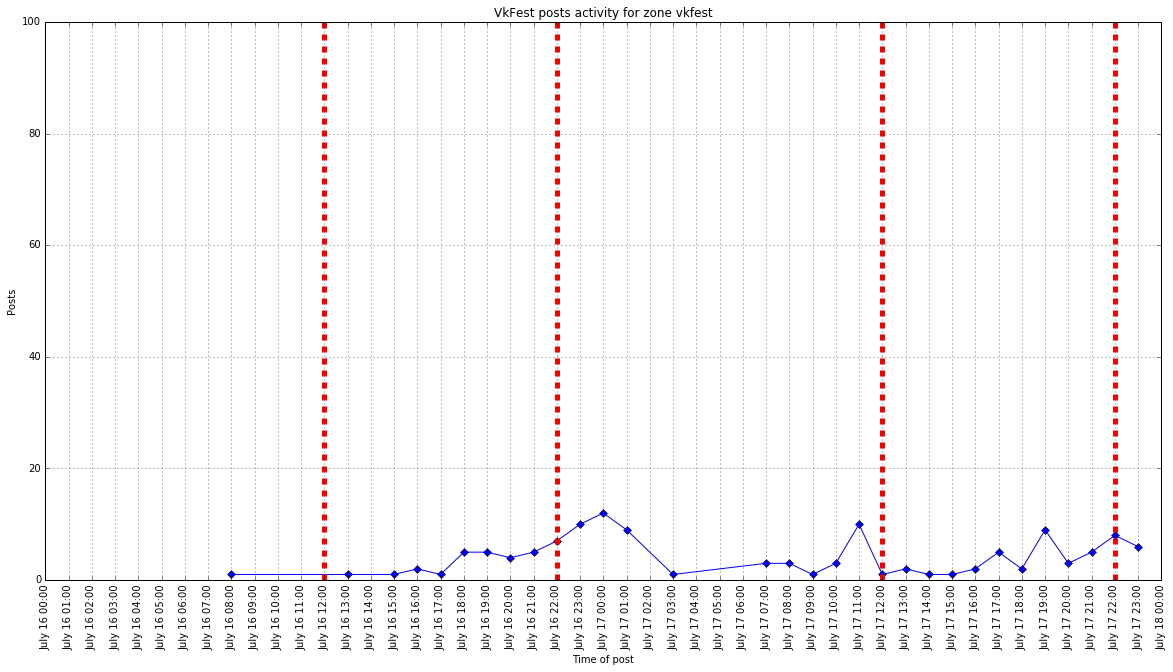

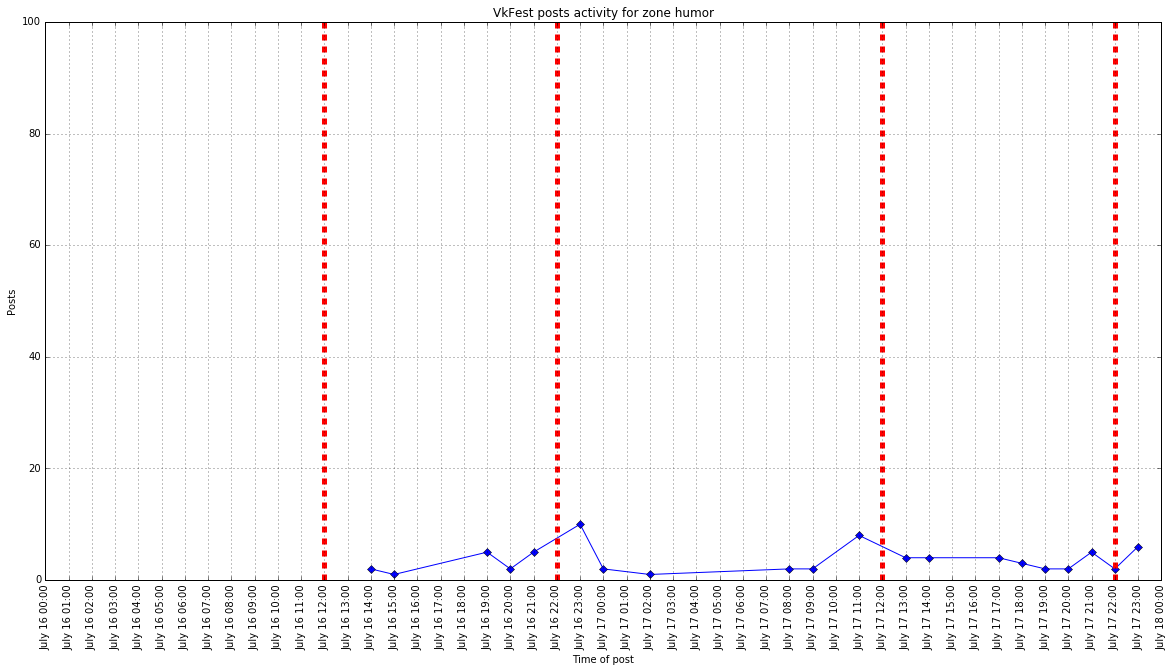

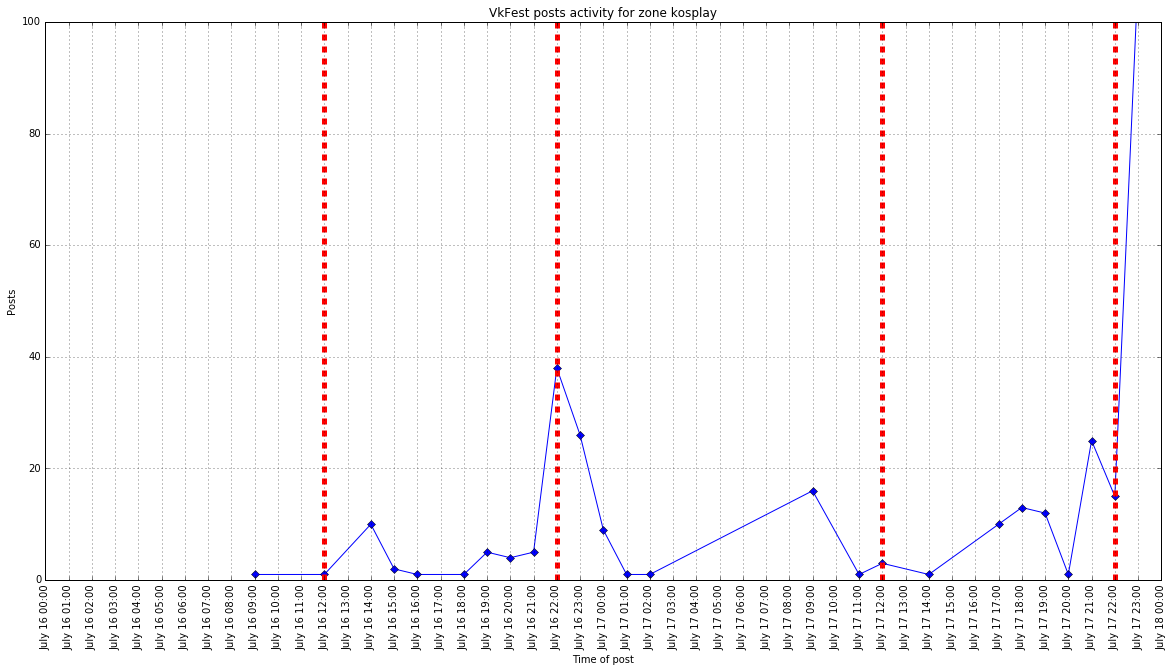

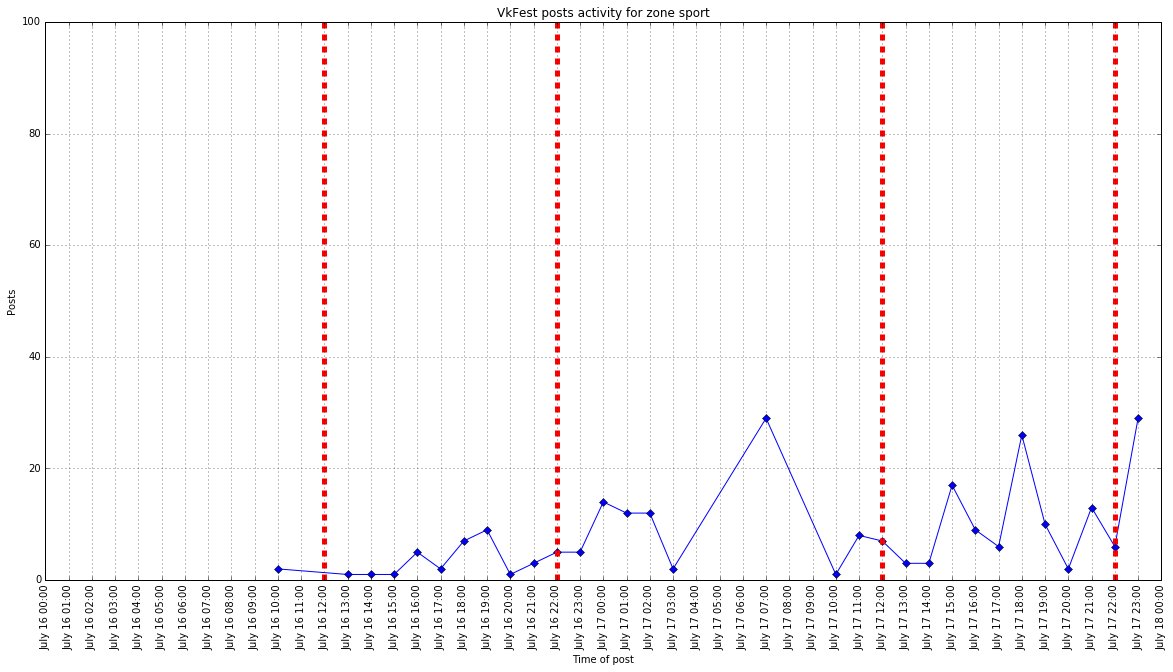

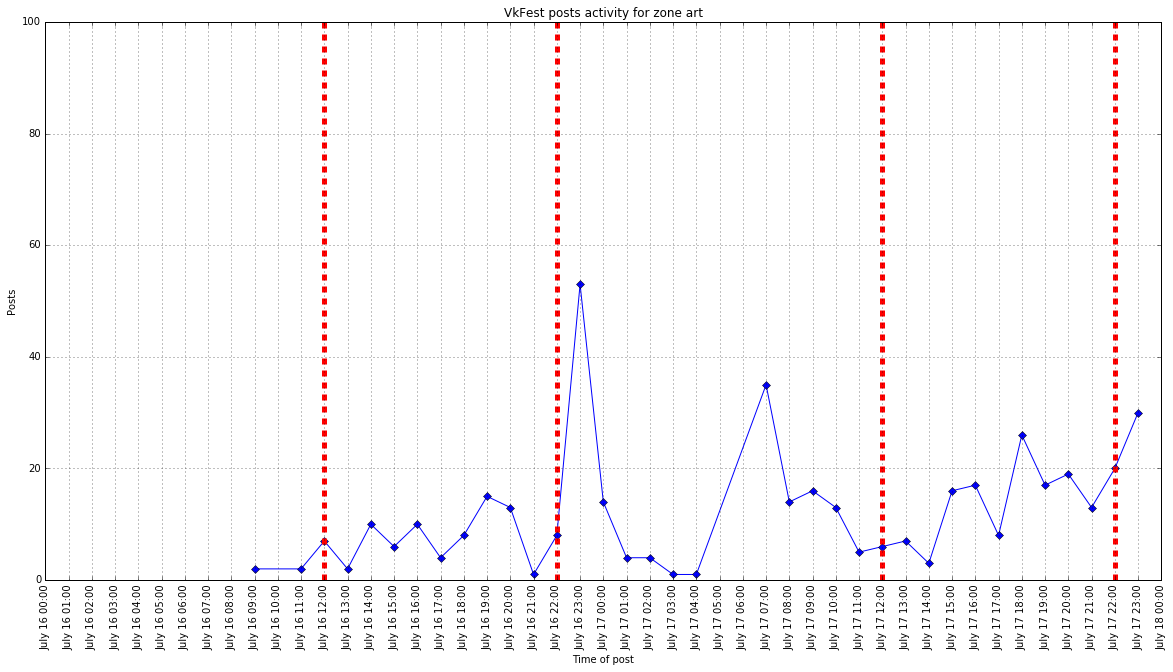

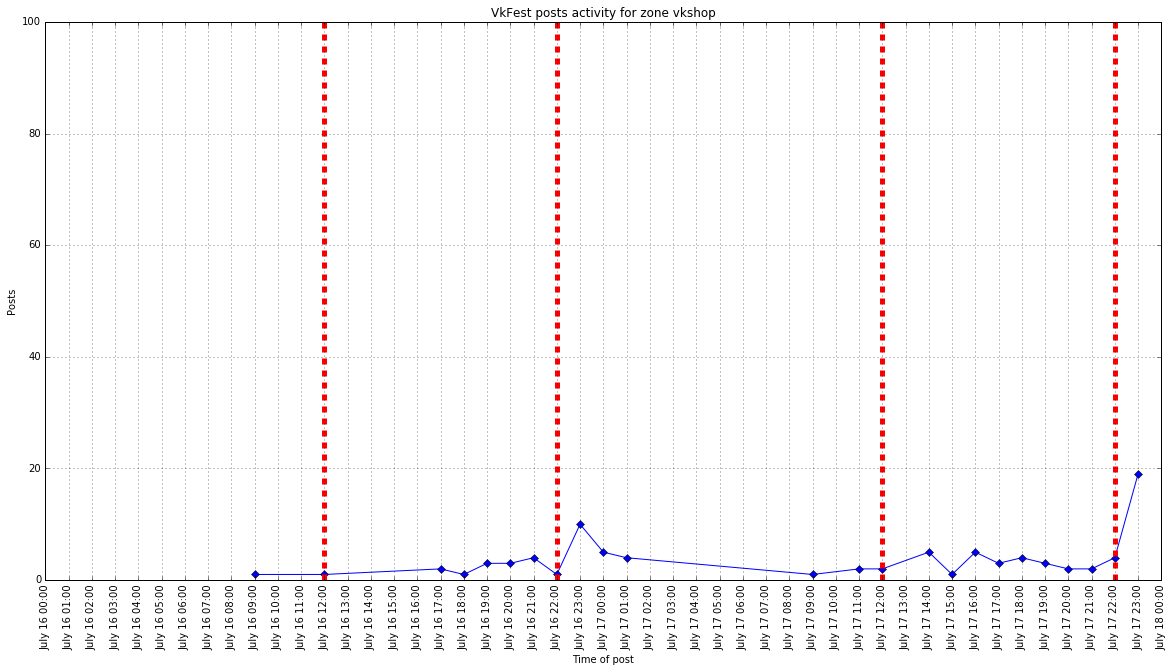

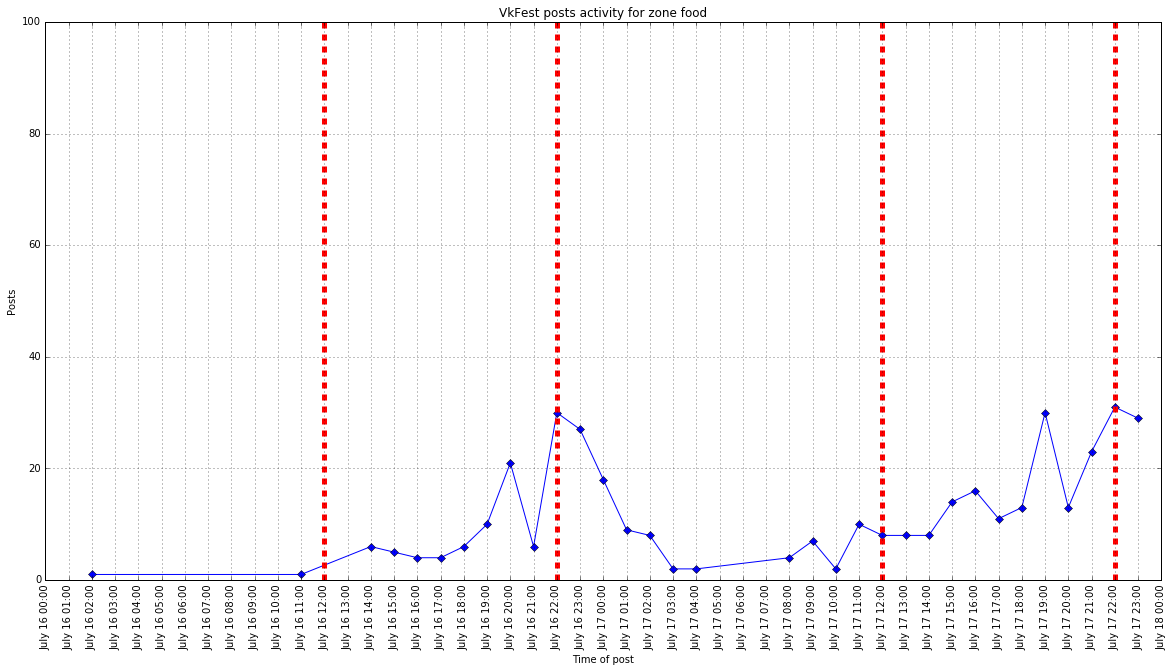

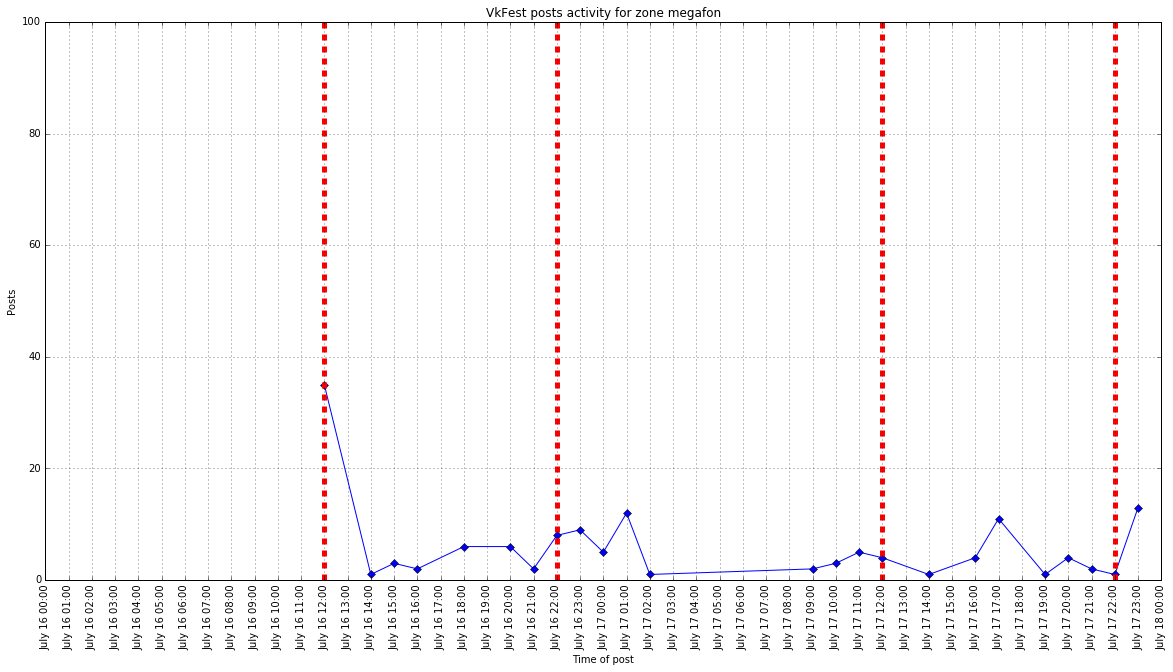

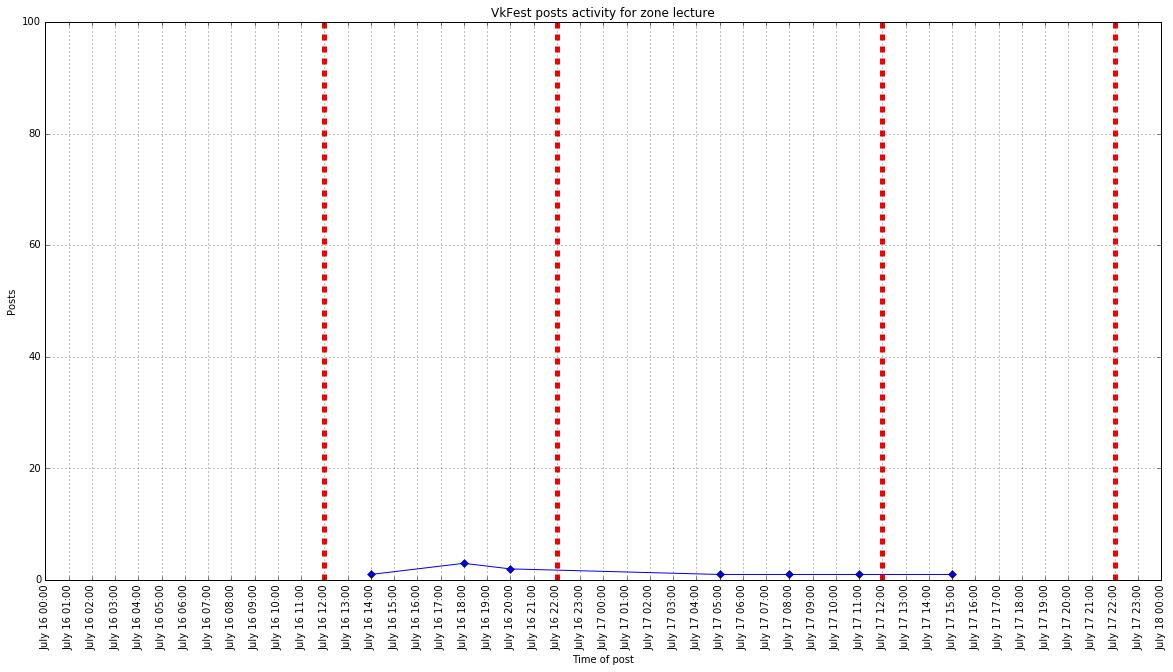

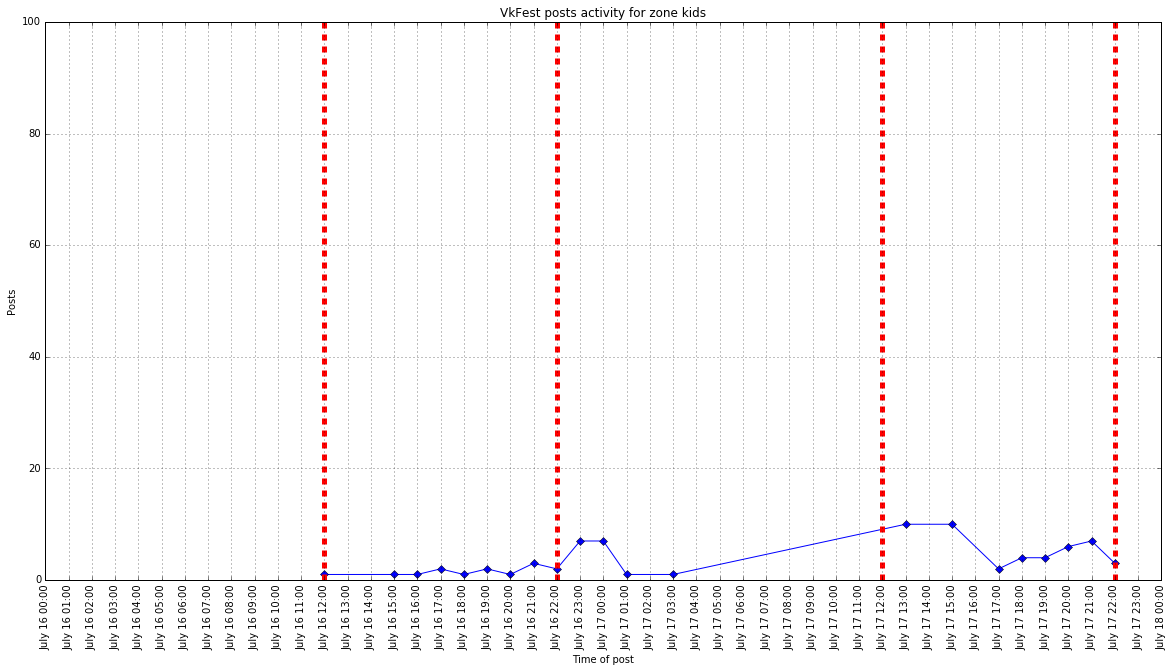

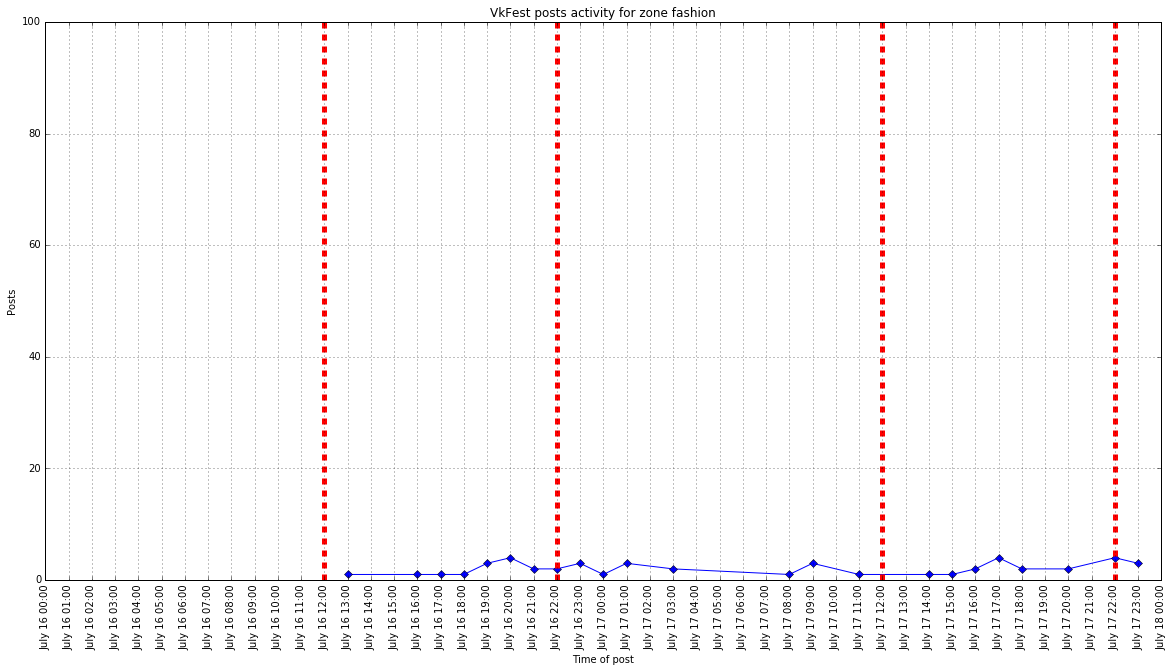

In [61]:
def plot_zone_activity(g):
    zone,zone_posts = g
    zone_posts = seq(zone_posts)
    print(zone, zone_posts.size())
    
    zone_posts_activity = zone_posts \
        .group_by(time_hour) \
        .map(lambda g: ((datetime(g[0][0],g[0][1],g[0][2],g[0][3],0,0), seq(g[1]).len()))) \
        .sorted(lambda g: g[0]) \
        .filter(lambda g: datetime(2016,7,16) <= g[0] < datetime(2016,7,18))
    
    plt.figure(figsize=(20, 10), dpi=300)
    plt.title(u'VkFest posts activity for zone ' + zone)
    plt.xlabel(u'Time of post')
    plt.ylabel(u'Posts')
    plt.plot(list(zone_posts_activity.map(lambda g: g[0])),
             list(zone_posts_activity.map(lambda g: g[1])),
             'gD-',
             color="blue",
             linewidth=1.0    
            )
    
    plt.plot([datetime(2016,7,16,12,0) for _ in range(2)],[0,100],'r--',linewidth=5.0)
    plt.plot([datetime(2016,7,16,22,0) for _ in range(2)],[0,100],'r--',linewidth=5.0)
    plt.plot([datetime(2016,7,17,12,0) for _ in range(2)],[0,100],'r--',linewidth=5.0)
    plt.plot([datetime(2016,7,17,22,0) for _ in range(2)],[0,100],'r--',linewidth=5.0)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('July %d %H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator())
    plt.xticks(rotation=90)
    plt.grid()
    plt.xlim([datetime(2016,7,16),datetime(2016,7,18)])
    plt.ylim([0,100])
    
posts_grouped_by_zone.for_each(plot_zone_activity)

plt.show()


53


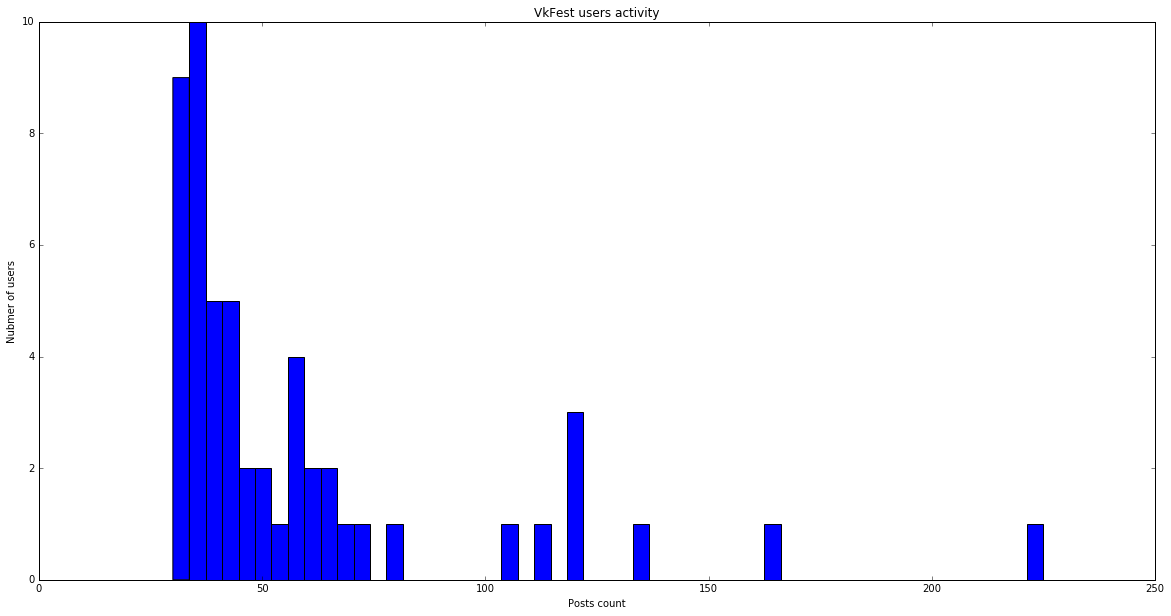

In [12]:
d = zoneposts \
    .group_by(lambda p: p['owner_id']) \
    .map(lambda g: (g[0], len(g[1]))) \
    .sorted(lambda g: g[1], reverse=True) \
    .filter(lambda g: g[1] >= 30)
    
print(d.len())    
    
plt.figure(figsize=(20, 10), dpi=300)
plt.title(u'VkFest users activity')
plt.xlabel(u'Posts count')
plt.ylabel(u'Nubmer of users')
plt.hist(list(d.map(lambda g: g[1])), bins=d.len(), color="blue", linewidth=1.0)
plt.show()

In [11]:
d.for_each(print)

(212564336, 225)
(155520499, 166)
(3455936, 134)
(13690863, 121)
(84995336, 119)
(37622859, 119)
(215900253, 113)
(1879844, 105)
(33472138, 80)
(2585331, 74)
(245950816, 69)
(220817673, 66)
(201647953, 64)
(174899099, 63)
(133934091, 60)
(4571701, 58)
(300252177, 57)
(336399, 56)
(152374819, 56)
(160693, 55)
(8821782, 51)
(94248505, 49)
(249808681, 48)
(11648575, 48)
(380956, 44)
(17206821, 44)
(14160615, 43)
(139384419, 43)
(11265944, 42)
(100971, 39)
(89232909, 39)
(12124542, 38)
(11839273, 38)
(945688, 38)
(1057016, 37)
(42632562, 37)
(2444304, 37)
(361058256, 37)
(176668013, 36)
(221857753, 35)
(287555609, 34)
(145382732, 34)
(199333388, 34)
(96492653, 34)
(1082909, 33)
(188740058, 33)
(282298608, 32)
(186379595, 32)
(2451980, 31)
(348606048, 31)
(2316597, 31)
(86640638, 30)
(41702284, 30)


In [73]:
def avg_interval(times):
    times = sorted(times.sorted(reverse=True))
#     print(len(times))
#     print(times)

    ts = []
    for i in range(len(times) - 1):
        ts.append(times[i] - times[i+1])
    
    rv = int(sum(ts)/len(ts) if len(ts) != 0 else 1000000000)
#     print('avg_interval = ', rv)
    return -rv

grouped = zoneposts \
    .group_by(lambda p: p['owner_id']) \
    .map(lambda g: (g[0], len(g[1]), g[1])) \
    .sorted(lambda g: g[1], reverse=True) \
    .filter(lambda g: g[1] >= 30) \
    .map(lambda g: (g[0], g[1], avg_interval(seq(g[2]).map(lambda p: p['date'])), seq(g[2]).sorted(lambda g: g['date']))) \
    .filter(lambda g: g[2] >= 500) \
    
#     .group_by(lambda g: int(g[1]/ 3))
    
    
    


In [79]:
import folium

def create_track(g):
    map_osm = folium.Map(location=[59.985794, 30.192587])
    
    seq(g[3]).for_each(lambda p: folium.Marker([p['lat'], p['long']], popup=datetime.fromtimestamp(p['date']).strftime("%Y-%m-%d %H:%M:%S")).add_to(map_osm))
    points = seq(g[3]).map(lambda p: [p['lat'], p['long']])
    folium.PolyLine(points).add_to(map_osm)
    map_osm.save(str(g[0]) + 'osm.html')
    
grouped.for_each(create_track)



